# Cambridge-analytica

In [63]:
def read_file(file_name): 
    data_list  = []
    with open(file_name, 'r') as f: 
        for line in f: 
            line = line.strip() 
            label = ' '.join(line[1:line.find("]")].strip().split())
            text = line[line.find("]")+1:].strip()
            data_list.append([label, text])
    return data_list 

In [64]:
file_name = "data/psychExp.txt"
psychExp_txt = read_file(file_name)

In [66]:
import re 
from collections import Counter

In [67]:
def ngram(token, n): 
    output = []
    for i in range(n-1, len(token)): 
        ngram = ' '.join(token[i-n+1:i+1])
        output.append(ngram) 
    return output

In [68]:
def create_feature(text, nrange=(1, 1)):
    text_features = [] 
    text = text.lower() 
    text_alphanum = re.sub('[^a-z0-9#]', ' ', text)
    for n in range(nrange[0], nrange[1]+1): 
        text_features += ngram(text_alphanum.split(), n)
        
    text_punc = re.sub('[a-z0-9]', ' ', text)
    text_features += ngram(text_punc.split(), 1)
    return Counter(text_features)

In [70]:
print(create_feature("I love you!"))
print(create_feature(" aly wins the gold!!!!!!  #olympics"))
print(create_feature(" aly wins the gold!!!!!!  #olympics", (1, 2)))

Counter({'i': 1, 'love': 1, 'you': 1, '!': 1})
Counter({'aly': 1, 'wins': 1, 'the': 1, 'gold': 1, '#olympics': 1, '!!!!!!': 1, '#': 1})
Counter({'aly': 1, 'wins': 1, 'the': 1, 'gold': 1, '#olympics': 1, 'aly wins': 1, 'wins the': 1, 'the gold': 1, 'gold #olympics': 1, '!!!!!!': 1, '#': 1})


**Cnvert the lables and Add features to text data**: 

In [71]:
def convert_label(item, name): 
    items = list(map(float, item.split()))
    label = ""
    for idx in range(len(items)): 
        if items[idx] == 1: 
            label += name[idx] + " "
    
    return label.strip()

In [31]:
emotions = ["joy", 'fear', "anger", "sadness", "disgust", "shame", "guilt"]

X_all = []
y_all = []
for label, text in psychExp_txt:
    y_all.append(convert_label(label, emotions))
    X_all.append(create_feature(text, nrange=(1, 4)))

In [76]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = \
    train_test_split(X_all, y_all, test_size = 0.2, random_state = 123)

In [77]:
from sklearn.metrics import accuracy_score

def train_test(clf, X_train, X_test, y_train, y_test):
    clf.fit(X_train, y_train)
    train_acc = accuracy_score(y_train, clf.predict(X_train))
    test_acc = accuracy_score(y_test, clf.predict(X_test))
    return train_acc, test_acc    

In [78]:
from sklearn.feature_extraction import DictVectorizer
vectorizer = DictVectorizer(sparse = True)
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [79]:
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

svc = SVC()
lsvc = LinearSVC(random_state=123)
rforest = RandomForestClassifier(random_state=123)
dtree = DecisionTreeClassifier()

clifs = [svc, lsvc, rforest, dtree]

print("| {:25} | {} | {} |".format("Classifier", "Training Accuracy", "Test Accuracy"))
print("| {} | {} | {} |".format("-"*25, "-"*17, "-"*13))
for clf in clifs: 
    clf_name = clf.__class__.__name__
    train_acc, test_acc = train_test(clf, X_train, X_test, y_train, y_test)
    print("| {:25} | {:17.7f} | {:13.7f} |".format(clf_name, train_acc, test_acc))

| Classifier                | Training Accuracy | Test Accuracy |
| ------------------------- | ----------------- | ------------- |
| SVC                       |         0.9067513 |     0.4512032 |


/usr/local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


| LinearSVC                 |         0.9988302 |     0.5768717 |
| RandomForestClassifier    |         0.9988302 |     0.5541444 |
| DecisionTreeClassifier    |         0.9988302 |     0.4518717 |


In [ ]:
from sklearn.model_selection import GridSearchCV

parameters = {'C':[1, 2, 3, 5, 10, 15, 20, 30, 50, 70, 100], 
             'tol':[0.1, 0.01, 0.001, 0.0001, 0.00001]}
print("1")
lsvc = LinearSVC(random_state=123)
print("2")
grid_obj = GridSearchCV(lsvc, param_grid = parameters, cv=5)
print("3")
grid_obj.fit(X_train, y_train)
print("4")

print("Validation acc: {}".format(grid_obj.best_score_))
print("Training acc: {}".format(accuracy_score(y_train, grid_obj.predict(X_train))))
print("Test acc    : {}".format(accuracy_score(y_test, grid_obj.predict(X_test))))
print("Best parameter: {}".format(grid_obj.best_params_))

1
2
3


/usr/local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [50]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(y_test, grid_obj.predict(X_test))
print(matrix)

[[112  27  16  23  12  19  19]
 [ 20 113  11  11  12  17   9]
 [  9  18 157   3  11  16  10]
 [ 19  12  15 107  12  17  36]
 [  7   9   7   7 155  18   8]
 [ 17   9  16  13  21 137  10]
 [ 31  19  10  30  17  10  82]]


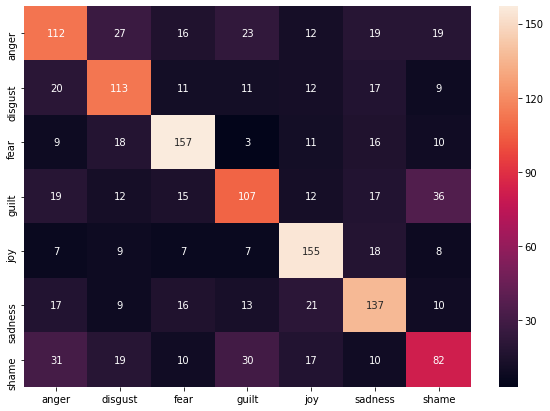

In [51]:
%matplotlib inline
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

l = ["joy", 'fear', "anger", "sadness", "disgust", "shame", "guilt"]
l.sort()
df_cm = pd.DataFrame(matrix, index = l, columns = l)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, fmt="d")
plt.show()

# Reference https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix

In [52]:
# Get counts for each label
label_freq = {}
for label, _ in psychExp_txt: 
    label_freq[label] = label_freq.get(label, 0) + 1

# print the labels and their counts in sorted order 
for l in sorted(label_freq, key=label_freq.get, reverse=True):
    print("{:10}({})  {}".format(convert_label(l, emotions), l, label_freq[l]))

joy       (1. 0. 0. 0. 0. 0. 0.)  1084
anger     (0. 0. 1. 0. 0. 0. 0.)  1080
sadness   (0. 0. 0. 1. 0. 0. 0.)  1079
fear      (0. 1. 0. 0. 0. 0. 0.)  1078
disgust   (0. 0. 0. 0. 1. 0. 0.)  1057
guilt     (0. 0. 0. 0. 0. 0. 1.)  1057
shame     (0. 0. 0. 0. 0. 1. 0.)  1045


By looking at the distributions of the labels, the data is distributed well. The errors probably happen because there are not enough data to train the classifier. Also, ngram with the range of 1 to 4 might not be enough or adding noise to the classifiers.

### Future Work 

To be able to accurately analyze the text, we probably need to have more data to train the classifiers. Also, it would be better to further experiment with features. (I'm not sure what we can use, but probably there is something to make features) At the same time, by adding more data with emoji, we can predict more emoji associated with the texts. 

<br> 
For the future work, we want to have more data and more emoji to analyze and represent the sentiment of the texts. 

### For fun

In [53]:
emoji_dict = {"joy":"😂", "fear":"😱", "anger":"😠", "sadness":"😢", "disgust":"😒", "shame":"😳", "guilt":"😳"}

In [61]:
t1 = "donald trump is an asshole"
t2 = "I don't like it"
t3 = "My car skidded on the wet street"
t4 = "I killed a cat"

texts = [t1, t2, t3, t4]
for text in texts: 
    features = create_feature(text, nrange=(1, 4))
    features = vectorizer.transform(features)
    prediction = grid_obj.predict(features)[0]
    print("{} {}".format(prediction, text))

fear donald trump is an asshole
sadness I don't like it
fear My car skidded on the wet street
guilt I killed a cat


### Reference 
+ [DeepMoji](https://www.media.mit.edu/projects/deepmoji/overview/)
+ [DeepMoji GitHub](https://github.com/bfelbo/DeepMoji)
+ [Multiclass and multilabel algorithms](http://scikit-learn.org/stable/modules/multiclass.html)
+ [sklearn.svm.SVC](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)
+ [sklearn.svm.LinearSVC](http://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html)
+ [sklearn.ensemble.RandomForestClassifie](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
+ [sklearn.tree.DecisionTreeClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)


In [ ]:
print("hello")